# Introduction to sentiment analysis with NLI

In this notebook, you will implement a sentiment scoring pipeline using a Natural Language Inference (NLI) model. 
You will analyze whether news headlines about S&P 500 companies have positive or negative sentiment and explore how this sentiment correlates with market returns.


## Install and Import librairies
Install necessary packages and import the required libraries for:
- Loading data
- Using transformer models
- Plotting and visualizing results
- Downloading financial data

In [58]:
%pip install hf_xet
%pip install yfinance

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import math
import torch
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sentence_transformers import CrossEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification

## Load news data
Load two datasets:
- `df_news.csv`: contains headlines and summaries
- `df_metadata.csv`: contains ticker symbols and company sector info

We drop duplicate summaries to avoid redundant sentiment scoring.

In [2]:
df_news = pd.read_csv('../df_news.csv')
df_news.drop_duplicates('SUMMARY', inplace=True)
display(df_news)

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29 04:33:58+00:00,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27 04:34:42+00:00,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22 14:08:00+00:00,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22 03:31:21+00:00,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19 04:41:32+00:00,StockStory,https://finance.yahoo.com/news/3-cash-producin...
...,...,...,...,...,...,...
4866,ZTS,2 Dividend Stocks to Buy With $500 and Hold Fo...,Zoetis is a leading animal health company with...,2025-05-23 10:30:00+00:00,Motley Fool,https://www.fool.com/investing/2025/05/23/2-di...
4867,ZTS,Zoetis (NYSE:ZTS) Declares US$0.50 Dividend Pe...,Zoetis (NYSE:ZTS) recently affirmed a dividend...,2025-05-22 17:49:43+00:00,Simply Wall St.,https://finance.yahoo.com/news/zoetis-nyse-zts...
4868,ZTS,Jim Cramer on Zoetis (ZTS): “It Does Seem to B...,We recently published a list of Jim Cramer Tal...,2025-05-21 18:14:38+00:00,Insider Monkey,https://finance.yahoo.com/news/jim-cramer-zoet...
4869,ZTS,Zoetis (ZTS) Upgraded to Buy: Here's Why,Zoetis (ZTS) might move higher on growing opti...,2025-05-21 16:00:08+00:00,Zacks,https://finance.yahoo.com/news/zoetis-zts-upgr...


In [3]:
df_meta = pd.read_csv('../df_metadata.csv')
display(df_meta)

,TICKER,COMPANY_NAME,SECTOR,INDUSTRY
0,MMM,3M Company,Industrials,Conglomerates
1,AOS,A. O. Smith Corporation,Industrials,Specialty Industrial Machinery
2,ABT,Abbott Laboratories,Healthcare,Medical Devices
3,ABBV,AbbVie Inc.,Healthcare,Drug Manufacturers - General
4,ACN,Accenture plc,Technology,Information Technology Services
...,...,...,...,...
485,XEL,Xcel Energy Inc.,Utilities,Utilities - Regulated Electric
486,XYL,Xylem Inc.,Industrials,Specialty Industrial Machinery
487,YUM,"Yum! Brands, Inc.",Consumer Cyclical,Restaurants
488,ZBH,"Zimmer Biomet Holdings, Inc.",Healthcare,Medical Devices


## Sentiment Analysis with NLI

In this section, you will apply a CrossEncoder NLI model (`cross-encoder/nli-deberta-v3-base`) to estimate sentiment from news headlines.

👉 **Instructions**:

1. Use a CrossEncoder NLI model to compute how much a news headline implies a **positive** or **negative** sentiment.
2. For each news title, compute the probability of it being **positive** and **negative**, and store them in `POSITIVE_PROB` and `NEGATIVE_PROB`.
3. Derive a final sentiment score by subtracting: `SENTIMENT = POSITIVE_PROB - NEGATIVE_PROB`.

✅ This score will serve as your sentiment signal, ranging from negative to positive.

> ℹ️ You are free to decide how to structure the input pairs and how to apply the model.


In [ ]:
model = CrossEncoder('cross-encoder/nli-deberta-v3-base')
hypotheses = [
    "This headline has a positive sentiment.",
    "This headline has a negative sentiment."
]

def get_sentiment_scores(headline):
    pairs = [(headline, hyp) for hyp in hypotheses]
    scores = model.predict(pairs)
    # model outputs [contradiction, neutral, entailment]
    return [score[2] for score in scores]

In [23]:
positive_probs = []
negative_probs = []
sentiments = []

for idx in range(len(df_news)):
    headline = df_news["SUMMARY"].iloc[idx]
    sentiment_scores = get_sentiment_scores(headline)
    positive_probs.append(sentiment_scores[0])
    negative_probs.append(sentiment_scores[1])
    sentiments.append(sentiment_scores[0] - sentiment_scores[1])

df_news["POSITIVE_PROB"] = positive_probs
df_news["NEGATIVE_PROB"] = negative_probs
df_news["SENTIMENT"] = sentiments

In [24]:
df_news.head()

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL,POSITIVE_PROB,NEGATIVE_PROB,SENTIMENT
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29 04:33:58+00:00,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...,4.973114,5.141531,-0.168417
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27 04:34:42+00:00,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...,4.873335,5.122154,-0.248819
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22 14:08:00+00:00,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...,0.154522,0.940822,-0.786300
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22 03:31:21+00:00,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...,5.338489,4.898020,0.440468
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19 04:41:32+00:00,StockStory,https://finance.yahoo.com/news/3-cash-producin...,4.675629,4.433777,0.241852


## Compare Sentiment with Returns

In this section, you'll explore how daily news sentiment aligns with market behavior.

👉 **Instructions**:

1. Group the news data by **publication date** and compute the **average sentiment per day**.
2. Download **daily stock prices** for the relevant tickers using `yfinance`.
3. Compute **daily returns** and use their average as a proxy for the market (e.g., S\&P 500).
4. Visualize both **daily sentiment** and **daily returns** over time using line plots.
5. Create a **dual y-axis chart** to compare trends more effectively.

✅ This section helps you assess whether changes in sentiment coincide with market movements.

> ℹ️ Focus on trend relationships, not just visual similarity—this is an opportunity to start thinking about predictive signals.

In [ ]:
df_news_grouped = df_news.groupby("PUBLICATION_DATE").agg(list)
df_news_grouped["AVG_POSITIVE_PROB"] = df_news_grouped["POSITIVE_PROB"].apply(np.mean)
df_news_grouped["AVG_NEGATIVE_PROB"] = df_news_grouped["NEGATIVE_PROB"].apply(np.mean)
df_news_grouped["AVG_SENTIMENT"] = df_news_grouped["SENTIMENT"].apply(np.mean)
df_news_grouped.head()

,TICKER,TITLE,SUMMARY,PROVIDER,URL,POSITIVE_PROB,NEGATIVE_PROB,SENTIMENT,AVG_POSITIVE_PROB,AVG_NEGATIVE_PROB,AVG_SENTIMENT
PUBLICATION_DATE,,,,,,,,,,,
2024-07-12 13:22:00+00:00,[DOC],[Is It Wise to Hold Healthpeak Properties (DOC...,[High demand for lab assets and rising senior ...,[Zacks],[https://finance.yahoo.com/news/wise-hold-heal...,[2.4937493801116943],[1.056098222732544],[1.4376511573791504],2.493749,1.056098,1.437651
2024-07-22 18:00:48+00:00,[DOC],[How To Earn $500 Per Month From Healthpeak Pr...,[We all have to visit doctors' offices from ti...,[Benzinga],[https://finance.yahoo.com/news/earn-500-per-m...,[4.237163543701172],[4.65846061706543],[-0.4212970733642578],4.237164,4.658461,-0.421297
2024-08-19 16:00:12+00:00,[DOC],[Healthpeak (DOC) Upgraded to Buy: Here's What...,[Healthpeak (DOC) might move higher on growing...,[Zacks],[https://finance.yahoo.com/news/healthpeak-doc...,[-1.0734097957611084],[-2.6252028942108154],[1.551793098449707],-1.073410,-2.625203,1.551793
2024-09-13 16:15:27+00:00,[DOC],[How the 10-year yield affects REITs],[Interest rate-sensitive REITs (Real Estate In...,[Yahoo Finance Video],[https://finance.yahoo.com/video/10-yield-affe...,[3.4485011100769043],[-0.6667801737785339],[4.115281105041504],3.448501,-0.666780,4.115281
2024-10-26 07:07:48+00:00,[DOC],[Healthpeak Properties Inc (DOC) Q3 2024 Earni...,[Healthpeak Properties Inc (DOC) reports robus...,[GuruFocus.com],[https://finance.yahoo.com/news/healthpeak-pro...,[0.12329191714525223],[-1.020884394645691],[1.1441763639450073],0.123292,-1.020884,1.144176


In [33]:
df_news_grouped.shape

(3748, 11)

In [135]:
df_news["PUBLICATION_DATE"] = pd.to_datetime(df_news["PUBLICATION_DATE"])
start_date = df_news["PUBLICATION_DATE"].min().strftime("%Y-%m-%d")
end_date = df_news["PUBLICATION_DATE"].max().strftime("%Y-%m-%d")
ticker_list = df_news["TICKER"].unique().tolist()

prices = yf.download(ticker_list, start=start_date, end=end_date)

C:\Users\hille\AppData\Local\Temp\ipykernel_2276\3109969491.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(ticker_list, start=start_date, end=end_date)
[*********************100%***********************]  487 of 487 completed


In [ ]:
daily_returns = prices["Close"].pct_change().dropna()
print(daily_returns.head())

Date
2024-07-15    0.016743
2024-07-16    0.001792
2024-07-17   -0.025296
2024-07-18   -0.020535
2024-07-19    0.000580
Name: AAPL, dtype: float64
Ticker             A      AAPL      ABBV      ABNB       ABT      ACGL  \
Date                                                                     
2024-07-15 -0.009226  0.016743 -0.004149  0.002998 -0.006849  0.006839   
2024-07-16  0.038547  0.001792  0.006963  0.027442 -0.002331 -0.000515   
2024-07-17 -0.018815 -0.025296  0.035875 -0.021552  0.019081  0.007826   
2024-07-18 -0.011461 -0.020535 -0.023564 -0.007568 -0.044039  0.003780   
2024-07-19 -0.001440  0.000580  0.006895  0.007557  0.019586 -0.021783   

Ticker           ACN      ADBE       ADI       ADM  ...       WST       WTW  \
Date                                                ...                       
2024-07-15  0.023307  0.011913 -0.003521 -0.013690  ... -0.008886 -0.003331   
2024-07-16  0.022431  0.001467  0.023599  0.018296  ...  0.028115  0.003760   
2024-07-17  0.0018

In [ ]:
# Function to get the daily returns of a specific ticker in a given day
def get_daily_returns(ticker, date):
    if isinstance(date, pd.Timestamp):
        date = date.strftime("%Y-%m-%d")
    try:
        return daily_returns.at[date, ticker]
    except (KeyError, ValueError):
        return np.nan

In [ ]:
# Testing the function
print(get_daily_returns("AAPL", "2024-07-12"))

nan


In [164]:
for date in df_news_grouped.index:
    daily_prices = []
    ticker_list = df_news_grouped.loc[date, "TICKER"]
    for ticker in ticker_list:
        date_str = date.strftime("%Y-%m-%d")
        price = get_daily_returns(ticker, date_str)
        daily_prices.append(price)
    # Filter out NaN values before calculating mean
    valid_prices = [p for p in daily_prices if not pd.isna(p)]
    if valid_prices:
        df_news_grouped.at[date, 'AVG_RETURN'] = np.mean(valid_prices)
    else:
        df_news_grouped.at[date, 'AVG_RETURN'] = np.nan


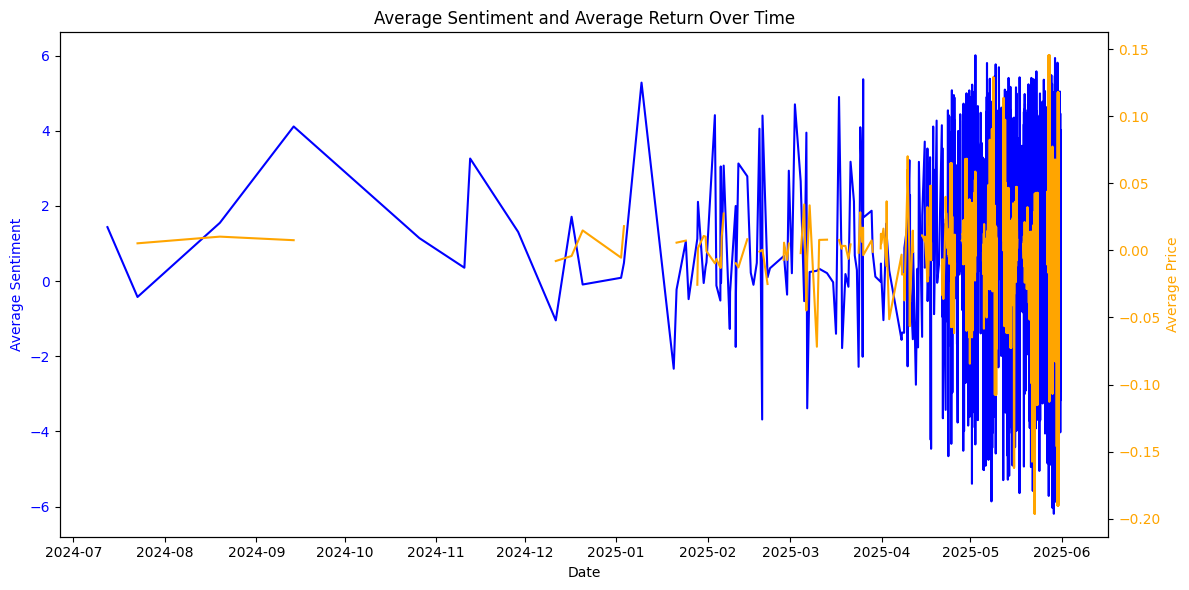

In [165]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Primary y-axis
ax1.set_xlabel("Date")
ax1.set_ylabel("Average Sentiment", color="blue")
ax1.plot(df_news_grouped.index, df_news_grouped["AVG_SENTIMENT"], label="Average Sentiment", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Secondary y-axis for average price
ax2 = ax1.twinx()
ax2.set_ylabel("Average Price", color="orange")
ax2.plot(df_news_grouped.index, df_news_grouped["AVG_RETURN"], label="Average Return", color="orange")
ax2.tick_params(axis="y", labelcolor="orange")

plt.title("Average Sentiment and Average Return Over Time")
fig.tight_layout()
plt.show()


## Compare Daily Portfolio Value Against Daily Average Sentiment

In this section, you will simulate a simple market portfolio and explore how its performance aligns with daily sentiment scores.

👉 **Instructions**:

1. Simulate a **market portfolio** by computing the cumulative return of the average daily return across all tickers.
2. Start the portfolio with an **initial value of 1.0** and track its value over time.
3. Plot the **daily average sentiment** and the **portfolio value** using a dual-axis line chart.

✅ This visualization lets you explore whether market sentiment leads or lags behind portfolio movements.

> ℹ️ Think about how this setup could inform a basic trading strategy—or whether sentiment could serve as a timing signal.


In [ ]:
df_portfolio = pd.DataFrame(index=df_news_grouped.index)
df_portfolio["Daily Returns"] = df_news_grouped["AVG_RETURN"]
df_portfolio.dropna(inplace=True)
df_portfolio["Portfolio Value"] = (1 + df_portfolio["Daily Returns"]).cumprod()
df_portfolio["Average Sentiment"] = df_news_grouped["AVG_SENTIMENT"]

In [185]:
df_portfolio.head(15)

,Daily Returns,Portfolio Value,Average Sentiment
PUBLICATION_DATE,,,
2024-07-22 18:00:48+00:00,0.005263,1.005263,-0.421297
2024-08-19 16:00:12+00:00,0.010242,1.015559,1.551793
2024-09-13 16:15:27+00:00,0.007586,1.023263,4.115281
2024-11-12 11:51:22+00:00,-0.011604,1.011389,3.262225
2024-12-11 12:30:53+00:00,-0.007929,1.003370,-1.043864
2024-12-16 21:07:41+00:00,-0.004169,0.999187,1.712558
2024-12-20 15:04:31+00:00,0.014869,1.014043,-0.089663
2025-01-02 15:40:33+00:00,-0.005427,1.008540,0.089845
2025-01-03 15:03:56+00:00,0.018049,1.026744,0.487063


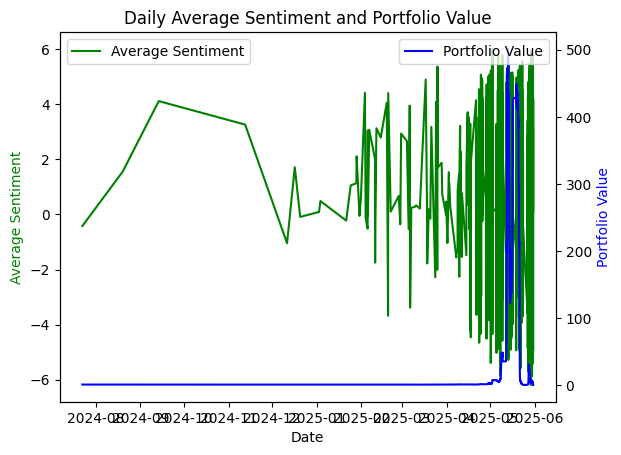

In [ ]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(df_portfolio.index, df_portfolio["Average Sentiment"], color="g", label="Average Sentiment")
ax2.plot(df_portfolio.index, df_portfolio["Portfolio Value"], color="b", label="Portfolio Value")

ax1.set_xlabel("Date")
ax1.set_ylabel("Average Sentiment", color="g")
ax2.set_ylabel("Portfolio Value", color="b")

plt.title("Daily Average Sentiment and Portfolio Value")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()

## Compute Sector-Level Sentiment and Returns

In this section, you’ll analyze how sector-level news sentiment compares to market performance for May. You’ll also measure whether sentiment correlates with returns.

👉 **Instructions**:

1. Group companies by **sector** using the metadata.
2. For each sector:

   * Compute **monthly average sentiment** (Feb to May).
   * (Optional) Count the number of headlines per month.
3. Compute **monthly stock returns** from price data and extract **May returns**.
4. Build a comparison table with:

   * `SECTOR`
   * `SENTIMENT` (May sentiment)
   * `RETURN` (May return)
5. Compute and print the **correlation** between May sentiment and May returns.

✅ This step helps evaluate whether optimistic news coverage for a sector is associated with better performance.

> 💡 Once your analysis is complete, consider:
>
> * Which sectors *looked* good in the news but didn’t perform?
> * Which sectors performed well despite neutral/negative sentiment?
> * Would you invest based on sentiment alone? Why or why not?



In [ ]:
df_companies_by_sector = df_meta.groupby("SECTOR").agg(list)

In [193]:
df_companies_by_sector.head()

,TICKER,COMPANY_NAME,INDUSTRY
SECTOR,,,
Basic Materials,"[APD, CF, CTVA, DOW, DD, EMN, ECL, FCX, IFF, L...","[Air Products and Chemicals, Inc., CF Industri...","[Specialty Chemicals, Agricultural Inputs, Agr..."
Communication Services,"[GOOGL, GOOG, T, CHTR, CMCSA, EA, FOXA, FOX, I...","[Alphabet Inc., Alphabet Inc., AT&T Inc., Char...","[Internet Content & Information, Internet Cont..."
Consumer Cyclical,"[ABNB, AMZN, AMCR, APTV, AZO, AVY, BALL, BBY, ...","[Airbnb, Inc., Amazon.com, Inc., Amcor plc, Ap...","[Travel Services, Internet Retail, Packaging &..."
Consumer Defensive,"[MO, ADM, BG, CPB, CHD, CLX, KO, CL, CAG, STZ,...","[Altria Group, Inc., Archer-Daniels-Midland Co...","[Tobacco, Farm Products, Farm Products, Packag..."
Energy,"[APA, BKR, CVX, COP, CTRA, DVN, FANG, EOG, EQT...","[APA Corporation, Baker Hughes Company, Chevro...","[Oil & Gas E&P, Oil & Gas Equipment & Services..."


In [ ]:
ticker_to_sector = dict(zip(df_meta["TICKER"], df_meta["SECTOR"]))

def get_sectors(tickers):
    return list({ticker_to_sector.get(t) for t in tickers if t in ticker_to_sector})

df_news_grouped["SECTOR"] = df_news_grouped["TICKER"].apply(get_sectors)

In [204]:
df_news_grouped[["TICKER", "SECTOR", "AVG_SENTIMENT"]].head(15)

,TICKER,SECTOR,AVG_SENTIMENT
PUBLICATION_DATE,,,
2024-07-12 13:22:00+00:00,[DOC],[Real Estate],1.437651
2024-07-22 18:00:48+00:00,[DOC],[Real Estate],-0.421297
2024-08-19 16:00:12+00:00,[DOC],[Real Estate],1.551793
2024-09-13 16:15:27+00:00,[DOC],[Real Estate],4.115281
2024-10-26 07:07:48+00:00,[DOC],[Real Estate],1.144176
2024-11-10 12:56:58+00:00,[SOLV],[Healthcare],0.357001
2024-11-12 11:51:22+00:00,[SOLV],[Healthcare],3.262225
2024-11-28 18:22:24+00:00,[EG],[Financial Services],1.309110
2024-12-11 12:30:53+00:00,[DOC],[Real Estate],-1.043864


In [ ]:
# Reset index to make PUBLICATION_DATE a column
df_news_grouped_reset = df_news_grouped.reset_index()
df_news_grouped_reset["PUBLICATION_DATE"] = pd.to_datetime(df_news_grouped_reset["PUBLICATION_DATE"])
df_exploded = df_news_grouped_reset.explode("SECTOR")
df_exploded["YEAR_MONTH"] = df_exploded["PUBLICATION_DATE"].dt.to_period("M")

# Filter for February to May
df_filtered = df_exploded[df_exploded["PUBLICATION_DATE"].dt.month.isin([2, 3, 4, 5])]

df_sentiment_avg = (
    df_filtered
    .groupby(["YEAR_MONTH", "SECTOR"])["AVG_SENTIMENT"]
    .mean()
    .reset_index()
    .sort_values(["YEAR_MONTH", "SECTOR"])
)

C:\Users\hille\AppData\Local\Temp\ipykernel_2276\2010236364.py:11: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_exploded["YEAR_MONTH"] = df_exploded["PUBLICATION_DATE"].dt.to_period("M")


In [211]:
df_sentiment_avg.head(35)

,YEAR_MONTH,SECTOR,AVG_SENTIMENT
0,2025-02,Basic Materials,-1.271648
1,2025-02,Consumer Cyclical,0.315572
2,2025-02,Financial Services,0.927718
3,2025-02,Healthcare,0.156836
4,2025-02,Industrials,1.814310
5,2025-02,Real Estate,0.223005
6,2025-02,Utilities,1.378713
7,2025-03,Basic Materials,1.704356
8,2025-03,Communication Services,4.095191
9,2025-03,Consumer Cyclical,-0.451347


In [ ]:
df_avg_returns = (
    df_filtered
    .groupby(["YEAR_MONTH", "SECTOR"])["AVG_RETURN"]
    .mean()
    .reset_index()
    .sort_values(["YEAR_MONTH", "SECTOR"])
)

In [232]:
df_avg_returns.head(35)

,YEAR_MONTH,SECTOR,AVG_RETURN
0,2025-02,Basic Materials,NaN
1,2025-02,Consumer Cyclical,0.000362
2,2025-02,Financial Services,-0.008898
3,2025-02,Healthcare,-0.000698
4,2025-02,Industrials,-0.001755
5,2025-02,Real Estate,-0.025060
6,2025-02,Utilities,0.004180
7,2025-03,Basic Materials,0.002206
8,2025-03,Communication Services,0.020216
9,2025-03,Consumer Cyclical,-0.014606


In [ ]:
df_may_returns = df_avg_returns[df_avg_returns["YEAR_MONTH"].dt.month == 5]
print(df_may_returns)

   YEAR_MONTH                  SECTOR  AVG_RETURN
28    2025-05         Basic Materials    0.002969
29    2025-05  Communication Services   -0.001023
30    2025-05       Consumer Cyclical    0.001027
31    2025-05      Consumer Defensive    0.000123
32    2025-05                  Energy    0.001508
33    2025-05      Financial Services   -0.000246
34    2025-05              Healthcare   -0.002909
35    2025-05             Industrials    0.002341
36    2025-05             Real Estate   -0.000245
37    2025-05              Technology   -0.000675
38    2025-05               Utilities   -0.003072


In [ ]:
df_may_sentiment = df_sentiment_avg[df_sentiment_avg["YEAR_MONTH"].dt.month == 5]
df_may_summary = pd.merge(df_may_sentiment, df_may_returns, on=["YEAR_MONTH", "SECTOR"], how="inner")
print(df_may_summary)

   YEAR_MONTH                  SECTOR  AVG_SENTIMENT  AVG_RETURN
0     2025-05         Basic Materials       0.650168    0.002969
1     2025-05  Communication Services       0.433476   -0.001023
2     2025-05       Consumer Cyclical       0.594399    0.001027
3     2025-05      Consumer Defensive       0.324662    0.000123
4     2025-05                  Energy       0.696634    0.001508
5     2025-05      Financial Services       0.835565   -0.000246
6     2025-05              Healthcare       0.692429   -0.002909
7     2025-05             Industrials       0.606592    0.002341
8     2025-05             Real Estate       0.952316   -0.000245
9     2025-05              Technology       0.861346   -0.000675
10    2025-05               Utilities       1.160772   -0.003072


In [249]:
df_corr = df_may_summary["AVG_RETURN"].corr(df_may_summary["AVG_SENTIMENT"])
print("Correlation May:", df_corr)

Correlation May: -0.4077284032416634


### **Question 1.** Which sectors *looked* good in the news? How did they perform?


In order to asses the sentiment of the news articles, we can look at the average sentiment scores for each sector.
This number represents the overall sentiment expressed in the news articles related to that sector, and can be used to gauge the market's perception of that sector's performance. The best performing sectors in terms of average sentiment are:
- Real State
- Technology
- Financial services

All of them with scores above 0.8, therefore we can conclude that the market has the best positive outlook on these sectors.

But regardless of the positive sentiment, we can notice that none of them performed exceptionally well in terms of actual returns. Therefore, it's important to consider other factors that may impact the performance of these sectors, such as economic conditions, regulatory changes, and market trends.

### **Question 2.** Which sectors performed well despite neutral/negative sentiment?


A sector that had a good performance and received negative sentiment is the Consumer Defensive sector, which had one of the lowest sentiment scores (0.32) but a positive average return of 0.000123, which indicates that despite the negative sentiment, the sector was able to deliver positive returns. Perhaps this is due to the sector's defensive nature, as it tends to be less sensitive to economic cycles and more resilient during downturns.

On the other hand, the Real Estate sector had the highest sentiment score (0.95) among all others, but also one of the lowest average return (-0.000245). This suggests that despite the positive sentiment, the sector struggled to deliver returns, possibly due to external factors such as changing consumer preferences or economic uncertainty.


### **Question 3.**  Would you invest based on sentiment alone? Why or why not?

I'm not convinced that sentiment analysis alone is sufficient to gauge the performance of these sectors. While it provides valuable insights into market perceptions, as I mentioned earlier, it's essential to consider other factors such as economic indicators, industry trends, and company fundamentals to get a comprehensive view of sector performance.

While sentiment analysis can be a useful tool for understanding market sentiment, it should be used in conjunction with other analytical methods to make informed investment decisions. Maybe in the near future, we can explore more advanced techniques that combine sentiment analysis with other data sources to improve our predictions.


### **Question 4.**  How would you go about testing a sentiment analysis strategy in a more robust way?

A more robust way to analyze sector performance would be to combine sentiment analysis with other data sources, such as financial metrics, market trends, and macroeconomic indicators. This multi-faceted approach could provide a more comprehensive view of the factors driving sector performance and help identify potential investment opportunities.

On the same line, improving machine learning models to incorporate these diverse data sources could enhance their predictive power and provide more accurate insights into sector performance. By leveraging advanced techniques such as feature engineering and ensemble methods, we can create models that better capture the complexities of the market and improve our investment strategies.